## Validation of 2nd-degree classification on simulated datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import time
import subprocess
from pdf2image import convert_from_path
from itertools import combinations, product
import pickle
from scipy.stats import gaussian_kde

plt.rcParams['font.family'] = 'sans-serif'   # Set the default
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 15
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
os.makedirs('pedsim_data',exist_ok=True)

### Generate pedigrees

In [9]:
from popgen_stats import generate_def_simple

def run_pedsim(par_file="par/ibd/gp1.def",
               output="output/ibd/gp1",
               gmap="refined_mf.simmap",
               o_file="output/ibd/gp1",
               i_file="interfere/nu_p_campbell.tsv"):
    """Wrapper to run pedsim"""
    !../../kinship_structure/ped-sim/ped-sim -d $par_file -m $gmap -o $output --intf $i_file --fam
    
def run_pedsim_pipeline(name = 'test', size = (100,150), generations = 10, mean_children = 2, rule = 'patrilineal', purity = 1, mean_spouse_num = 1,
                        plot = False, from_folder = None, max_generation_size = 50):
    
    if from_folder is None:
        write_content = generate_def_simple(name = name, size = size, generations = generations,
                                            mean_children = mean_children, rule = rule, purity = purity, 
                                            mean_spouse_num =  mean_spouse_num, max_generation_size = max_generation_size)
        
        datestamp = time.strftime("%Y_%m_%d")
        os.makedirs(f'./pedsim_data/{datestamp}',exist_ok=True)
        timestamp = time.strftime("%H_%M_%S")
        dirs = sorted(os.listdir(f'./pedsim_data/{datestamp}'),key = lambda x:int(x.split('_')[-1]), reverse=True)
        
        if len(dirs)>0:
            current_num = int(dirs[0].split('_')[-1])
        else:
            current_num = 0
        
        the_folder = f'./pedsim_data/{datestamp}/{timestamp}_{current_num+1}'
        os.makedirs(the_folder)
        
        # Write def
        with open(f"{the_folder}/{name}.def", "w") as def_file:
            def_file.write(write_content)
            def_file.write("\n")
        
        # Write log
        with open(f"{the_folder}/log.txt", "a") as log_file:
            log_file.write(f'generate_def_simple, {datestamp}_{timestamp}\n')
            log_file.write(f'size = {size}\n')
            log_file.write(f'generations = {generations}\n')
            log_file.write(f'mean_children = {mean_children}\n')
            log_file.write(f'purity = {purity}\n')
            log_file.write(f'mean_spouse_num = {mean_spouse_num}\n')
    
    else:
        datestamp = from_folder.split('/')[-2]
        the_folder = from_folder
        
        if not os.path.exists(f'{the_folder}/{name}.def'):
            write_content = generate_def_simple(name = name, size = size, generations = generations,
                                            mean_children = mean_children, rule = rule, purity = purity, 
                                            mean_spouse_num =  mean_spouse_num)
            with open(f"{the_folder}/{name}.def", "w") as def_file:
                def_file.write(write_content)
                def_file.write("\n")
    
    # Run pedsim
    run_pedsim(par_file=f"{the_folder}/{name}.def",
               output=f"{the_folder}/{name}",
               gmap="../../kinship_structure/ped-sim/refined_mf.simmap",
               i_file="../../kinship_structure/ped-sim/interfere/nu_p_campbell.tsv")
    
    timestamp = time.strftime("%H_%M_%S")
    with open(f"{the_folder}/log.txt", "a") as log_file:
        log_file.write(f'run pedsim, {datestamp}_{timestamp}\n')
    
    # Draw pedigree
    if plot:
        file_path = f"{the_folder}/{name}-everyone.fam"
        subprocess.run(["Rscript", "../../kinship_structure/ped-sim/plot-fam-slave-2.R", file_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        # subprocess.run(["Rscript", "../../ped-sim-master/plot-fam-slave-2.R", file_path], text=True)
        
        pdf_path = f"{the_folder}/{name}-everyone_plot.pdf"
        images = convert_from_path(pdf_path)
        img = images[0]
        plt.figure(dpi=600)
        plt.imshow(img)
        plt.title(name)
        plt.axis('off')
        plt.show()
    
    return f"{the_folder}/{name}"    

In [ ]:
## sanity check
run_pedsim_pipeline(generations=9, size = (150,200),mean_children=1.5, mean_spouse_num=1.5, max_generation_size=50)

generated patrilineal family tree with 177 valid individuals
Pedigree simulator!  v1.4.5    (Released 13 Dec 2024)

  Def file:		./pedsim_data/2025_04_03/00_09_09_3/test.def
  Map file:		../../kinship_structure/ped-sim/refined_mf.simmap
  Input VCF:		[none: no genetic data]
  Output prefix:	./pedsim_data/2025_04_03/00_09_09_3/test

  Random seed:		3905205625

  Interference file:	../../kinship_structure/ped-sim/interfere/nu_p_campbell.tsv

Simulating haplotype transmissions... done.
Printing IBD segments... done.
Printing fam file... done.  (Do not use with PLINK data: see README.md)

To simulate genetic data, must use an input VCF with 46 founders.


'./pedsim_data/2025_04_03/00_09_09_3/test'

### Get relative list from fam

In [6]:
def get_father(fam, iid):
    if iid != '0':
        return fam[fam[1]==iid][2].values[0]
    else:
        return '0'
def get_mother(fam, iid):
    if iid != '0':
        return fam[fam[1]==iid][3].values[0]
    else:
        return '0'

def get_grand(fam, iid, sex_list):
    grand = iid
    for sex in sex_list:
        if sex == 1: # male
            grand =  get_father(fam, grand)
        elif sex == 2: # female
            grand = get_mother(fam, grand)
    return grand

def get_all_grands(fam, iid, generations):
    grands = [iid]
    for i in range(generations):
        for individ in grands.copy():
            grands.append(get_father(fam, individ))
            grands.append(get_mother(fam, individ))
            grands.remove(individ)
        grands = [x for x in grands if x != '0']     
    return set(grands)

# A brute force way of finding MRCAs
def get_all_ancestors(fam,individ, return_gen = False):
    ancestors = {individ}
    if return_gen:
        ancestors_with_gen = {individ:0}
    old_ancestors = {}
    gen_num = 0
    while ancestors != old_ancestors:
        new_ancestors = ancestors.difference(old_ancestors)
        old_ancestors = ancestors.copy()
        gen_num += 1
        for individ in new_ancestors:
            father = get_father(fam,individ)
            mother = get_mother(fam,individ)
            if father != '0':
                ancestors.add(father)
                if return_gen:
                    ancestors_with_gen[father] = gen_num
            if mother != '0':
                ancestors.add(mother)
                if return_gen:
                    ancestors_with_gen[mother] = gen_num
    if return_gen:
        return ancestors, ancestors_with_gen
    return ancestors

def get_MRCAs(fam, pair, return_coef = False):
    # Get MRCAs of two individuals
    # inbreeding is not taken into account; for pedigrees with inbreeding, the literally most recent ancestors are found
    MRCAs = {}
    if return_coef:
        ancestors_1, ancestors_1_with_gen = get_all_ancestors(fam,pair[0], return_gen=True)
    else:
        ancestors_1 = get_all_ancestors(fam,pair[0])
    gen2 = 0
    ancestors_2_this_gen = {pair[1]}
    MRCAs = ancestors_2_this_gen.intersection(ancestors_1)
    while (not MRCAs) & bool(ancestors_2_this_gen):
        gen2 += 1
        for individ in ancestors_2_this_gen.copy():
            father = get_father(fam,individ)
            mother = get_mother(fam,individ)
            if father != '0':
                ancestors_2_this_gen.add(father)
            if mother != '0':
                ancestors_2_this_gen.add(mother)
            ancestors_2_this_gen.remove(individ)
        MRCAs = ancestors_2_this_gen.intersection(ancestors_1)
    if return_coef:
        coef = 0
        if MRCAs:
            gen1 = ancestors_1_with_gen[list(MRCAs)[0]]
            # print(gen1,gen2)
            coef = 2**(-gen1-gen2-1)*len(MRCAs)
        return set(MRCAs),coef
    return set(MRCAs)

fam = pd.read_csv('./pedsim_data/2024_03_15/17_37_31_27/test-everyone.fam',sep = ' ',header=None)
get_MRCAs(fam, ['test1_g5-b1-i1','test1_g5-b2-i1'], return_coef=True)

({'test1_g4-b1-i1'}, 0.125)

### Get coef from fam

In [ ]:
from ancIBD_funcs import to_hapsburg_ibd_df

def get_coef_from_fam(fam_file):
    fam = pd.read_csv(fam_file,sep = ' ',header=None)
    
    basename = os.path.splitext(fam_file)[0][:-9]
    IBD_sum = to_hapsburg_ibd_df(path_segments = f'{basename}.seg',savepath = f'{basename}_summary.tsv')
    
    df = pd.DataFrame(columns=['iid1', 'iid2', 'kinship_coefficient', 'IBD2_fraction', 'segment_count', 'kinship'])
    
    combs = list(zip(IBD_sum['iid1'], IBD_sum['iid2']))
    for i,comb in enumerate(combs):
        _, coef = get_MRCAs(fam,comb,return_coef=True)
        df.loc[i,'iid1'] = comb[0]
        df.loc[i,'iid2'] = comb[1]
        df.loc[i,'kinship_coefficient'] = coef
        df.loc[i,'IBD2_fraction'] = comb[1]
        df.loc[i,'segment_count'] = IBD_sum.loc[i,'n_IBD>20']
        df.loc[i,'kinship'] = round(-np.log2(coef)-1)

    df.to_csv(f'{basename}.coef',sep='\t', index=False, header=False)

In [211]:
get_coef_from_fam('./pedsim_data/2024_03_17/10_46_06_3/test-everyone.fam')

Saved 3770 individual IBD pairs to: ./pedsim_data/2024_03_17/10_46_06_3/test_summary.tsv


### Classify mutual relatives

In [8]:
def classify_2nd_degree(fam,pair):
    if (get_father(fam,pair[0]) == get_father(fam,pair[1])) & (get_mother(fam,pair[0]) != get_mother(fam,pair[1])):
        return pair,'HS'
    elif pair[0] in get_all_grands(fam,pair[1],2):
        return pair,'GP' # age pair[0]>pair[1]
    elif pair[1] in get_all_grands(fam,pair[0],2):
        return (pair[1],pair[0]),'GP' # age pair[0]<pair[1]
    elif (get_all_grands(fam,pair[0],1).issubset(get_all_grands(fam,pair[1],2))) & (pair[0] not in get_all_grands(fam,pair[1],1)):
        return pair,'AV'
    elif (get_all_grands(fam,pair[1],1).issubset(get_all_grands(fam,pair[0],2))) & (pair[1] not in get_all_grands(fam,pair[0],1)):
        return (pair[1],pair[0]), 'AV'
    else:
        return pair,'other'

def classify_mutual_relative(fam, pair_spec, individ):
    # classify mutual relatives into 5 categories: 
    # 1 - (E(R1),E(R2)) = (0.25,1)
    # 2 - (E(R1),E(R2)) = (0.25,0.5)
    # 3 - (E(R1),E(R2)) = (0.5,0.5)
    # 4 - (E(R1),E(R2)) = (0.5,0.25)
    # 5 - (E(R1),E(R2)) = (1,0.25)
    
    pair, pair_type = pair_spec
    MRCAs = (get_MRCAs(fam, (pair[0], individ)), get_MRCAs(fam, (pair[1], individ)))
    if bool(MRCAs[0]) & bool(MRCAs[1]):
        if pair_type == 'HS':
            if pair[0] in MRCAs[0]:
                return 1
            elif pair[1] in MRCAs[1]:
                return 5
            else:
                return 3
        elif pair_type == 'GP':
            if pair[1] in get_MRCAs(fam, (pair[1], individ)): # grandchild's offspring
                return 5
            elif MRCAs[1] == get_all_grands(fam,pair[1],1):
                return 4
            elif MRCAs[1].issubset(get_all_grands(fam,pair[1],1)): # half sibling of grandson, a previously overlooked situation
                assert len(MRCAs[1])==1
                return 3
            elif (len(MRCAs[0])==1) & (len(MRCAs[1])==2) & (pair[0] in MRCAs[0]):
                return 2
            else:
                return 1
        elif pair_type == 'AV':
            if pair[1] in MRCAs[1]: # nephew's offspring
                return 5
            elif pair[0] in MRCAs[0]: # uncle's offspring
                return 1
            elif MRCAs[1] == get_all_grands(fam,pair[1],1):
                return 4
            elif MRCAs[1].issubset(get_all_grands(fam,pair[1],1)): # half sibling of nephew, a previously overlooked situation
                assert len(MRCAs[1])==1
                return 3
            else:
                return 2
        else:
            return None  
    else:
        return None

In [9]:
fam = pd.read_csv('./pedsim_data/2024_03_17/10_46_06_3/test-everyone.fam',sep = ' ',header=None)
coef = pd.read_csv('./pedsim_data/2024_03_17/10_46_06_3/test.coef',sep = '\t',header=None)
seg = pd.read_csv('./pedsim_data/2024_03_17/10_46_06_3/test.seg',sep = '\t',header=None)

pair_spec = classify_2nd_degree(fam,('test1_g2-b1-i1','test1_g4-b2-i1'))
print(pair_spec)
y_type = classify_mutual_relative(fam, pair_spec, 'test1_g3-b1-i1')
print(y_type)

(('test1_g2-b1-i1', 'test1_g4-b2-i1'), 'GP')
2


### multi-way IBD functions
Extensions for statistics using ped-sim generated data.

In [12]:
import sys
sys.path.append("..")

from multi_way_IBD import get_mutual_relative, add_noise, filter_segments, calculate_length_and_intersections, find_intersection_total
from multi_way_IBD import get_R1_R2

    
def get_R1_R2_stat(seg, coef, fam, order_thres = (5,5), reorder = False, return_length = False, noise = 0):
    sec_pairs = coef[coef[5]==2].copy()
    sec_pairs.reset_index(inplace = True)
    all_R1_R2s = []
    all_y_names = []
    
    if noise!=0:
        seg = add_noise(seg,noise)
    for index,row in sec_pairs.iterrows():
        pair_raw = (row[0],row[1])
        pair_spec = classify_2nd_degree(fam,pair_raw)
        
        pair = pair_spec[0]
        if (index%50 == 0) | (index+1==len(sec_pairs)):
            print(f'{pair}, {index+1}/{len(sec_pairs)} pairs done')
        mutual_relative_list = get_mutual_relative(pair,coef,order_thres)
        
        R1_R2_summary = np.zeros((len(mutual_relative_list),2))
        l1_l2_summary = np.zeros((len(mutual_relative_list),2))
        y_type_summary = np.zeros((len(mutual_relative_list),))
        all_y_names.append(mutual_relative_list)
        
        for i, individ in enumerate(mutual_relative_list):
            spec_seg_1 = filter_segments(seg, (pair[0],individ))
            spec_seg_2 = filter_segments(seg, (pair[1],individ))
            IBD_len_1, _ = calculate_length_and_intersections(spec_seg_1)
            IBD_len_2, _ = calculate_length_and_intersections(spec_seg_2)
            IBD_len_mutual, _ = find_intersection_total(spec_seg_1, spec_seg_2)
            
            if (IBD_len_1>0) & (IBD_len_2>0):
                y_type = classify_mutual_relative(fam, pair_spec, individ)
                y_type_summary[i] = y_type
                if reorder:
                    R1_R2_summary[i,0] = min(IBD_len_mutual/IBD_len_1, IBD_len_mutual/IBD_len_2)
                    R1_R2_summary[i,1] = max(IBD_len_mutual/IBD_len_1, IBD_len_mutual/IBD_len_2)
                else:
                    R1_R2_summary[i,0] = IBD_len_mutual/IBD_len_1
                    R1_R2_summary[i,1] = IBD_len_mutual/IBD_len_2
                
                if return_length:
                    l1_l2_summary[i,0] = IBD_len_1
                    l1_l2_summary[i,1] = IBD_len_2
        
        if return_length:
            all_R1_R2s.append((*pair_spec,R1_R2_summary,l1_l2_summary,y_type_summary))
        else:
            all_R1_R2s.append((*pair_spec,R1_R2_summary,y_type_summary))
        
    return all_R1_R2s, all_y_names

def get_R1_R2_stat_sample(seg, coef1, fam, order_thres = (5,5), reorder = False, return_length = False, noise = 0, sample_num = 30):
    individ_list = coef1[0].tolist() + coef1[1].tolist()
    individ_list = list(set(individ_list))
    sampled = random.sample(individ_list, min(sample_num, len(individ_list)))
    
    coef = coef1[coef1[0].isin(sampled) & coef1[1].isin(sampled)]
    
    sec_pairs = coef[coef[5]==2].copy()
    sec_pairs.reset_index(inplace = True)
    all_R1_R2s = []
    
    if noise!=0:
        seg = add_noise(seg,noise)
    for index,row in sec_pairs.iterrows():
        pair_raw = (row[0],row[1])
        pair_spec = classify_2nd_degree(fam,pair_raw)
        
        pair = pair_spec[0]
        if (index%50 == 0) | (index+1==len(sec_pairs)):
            print(f'{pair}, {index+1}/{len(sec_pairs)} pairs done')
        mutual_relative_list = get_mutual_relative(pair,coef,order_thres)
        
        R1_R2_summary = np.zeros((len(mutual_relative_list),2))
        l1_l2_summary = np.zeros((len(mutual_relative_list),2))
        y_type_summary = np.zeros((len(mutual_relative_list),))
        
        for i, individ in enumerate(mutual_relative_list):
            spec_seg_1 = filter_segments(seg, (pair[0],individ))
            spec_seg_2 = filter_segments(seg, (pair[1],individ))
            IBD_len_1, _ = calculate_length_and_intersections(spec_seg_1)
            IBD_len_2, _ = calculate_length_and_intersections(spec_seg_2)
            IBD_len_mutual, _ = find_intersection_total(spec_seg_1, spec_seg_2)
            
            if (IBD_len_1>0) & (IBD_len_2>0):
                y_type = classify_mutual_relative(fam, pair_spec, individ)
                y_type_summary[i] = y_type
                if reorder:
                    R1_R2_summary[i,0] = min(IBD_len_mutual/IBD_len_1, IBD_len_mutual/IBD_len_2)
                    R1_R2_summary[i,1] = max(IBD_len_mutual/IBD_len_1, IBD_len_mutual/IBD_len_2)
                else:
                    R1_R2_summary[i,0] = IBD_len_mutual/IBD_len_1
                    R1_R2_summary[i,1] = IBD_len_mutual/IBD_len_2
                
                if return_length:
                    l1_l2_summary[i,0] = IBD_len_1
                    l1_l2_summary[i,1] = IBD_len_2
        
        if return_length:
            all_R1_R2s.append((*pair_spec,R1_R2_summary,l1_l2_summary,y_type_summary))
        else:
            all_R1_R2s.append((*pair_spec,R1_R2_summary,y_type_summary))
        
    return all_R1_R2s

## Main simulation

See supplementary note 2 for details

In [ ]:
reps = 50
data_list = []
for i in range(reps):
    timestamp = time.strftime("%H_%M_%S")
    basename =  run_pedsim_pipeline(generations=9, size = (150,200), mean_children=1.5, mean_spouse_num=1.5, max_generation_size=40, name = f'test_{timestamp}')
    get_coef_from_fam(f'{basename}-everyone.fam')
    
    fam = pd.read_csv(f'{basename}-everyone.fam',sep = ' ',header=None)
    coef = pd.read_csv(f'{basename}.coef',sep = '\t',header=None)
    seg = pd.read_csv(f'{basename}.seg',sep = '\t',header=None)
    
    all_R1_R2s = get_R1_R2_stat(seg, coef, fam, order_thres = (3,5), reorder = False, return_length = True, noise=0.5)
    data_list.append(all_R1_R2s)
    
with open('./data_backup/0319_test2.data','wb') as file_handle:
    pickle.dump(data_list,file_handle)

In [3]:
import pickle
with open('./data_backup/0319_test2.data','rb') as file_handle:
    data_list = pickle.load(file_handle)

In [6]:
def merge_category_R1R2s(data_list):
    pair_types = ['GP','AV','HS']
    y_types = [1,2,3,4,5]
    categories = list(product(pair_types,y_types))
    R1R2_data = {}
    
    for all_R1_R2s in data_list:
        for category in categories:
            pair_type,y_type = category
            filtered_R1R2 = list(filter(lambda x: x[1] == pair_type, all_R1_R2s))
            R1R2_summary = np.concatenate([tup[2][tup[-1]==y_type] for tup in filtered_R1R2], axis = 0)
            l1l2_summary = np.concatenate([tup[3][tup[-1]==y_type] for tup in filtered_R1R2], axis = 0)
            
            if category not in R1R2_data:
                R1R2_data[category] = (R1R2_summary,l1l2_summary)
            else:
                R1R2_data[category] = (np.concatenate((R1R2_data[category][0],R1R2_summary),axis = 0),
                                       np.concatenate((R1R2_data[category][1],l1l2_summary),axis = 0))
    return R1R2_data

def get_type_number(data_list):
    pair_types = ['GP','AV','HS']
    y_types = [1,2,3,4,5]
    type_numbers = np.zeros((len(pair_types),len(y_types)))
    
    for all_R1_R2s in data_list:
        for i1,pair_type in enumerate(pair_types):
            filtered_R1R2 = list(filter(lambda x: x[1] == pair_type, all_R1_R2s))
            for i2, y_type in enumerate(y_types):
                type_numbers[i1,i2] += sum([np.sum(tup[-1]==y_type) for tup in filtered_R1R2])
    
    return type_numbers

In [7]:
R1R2_data = merge_category_R1R2s(data_list)
y_type_numbers = get_type_number(data_list)
y_type_probs = y_type_numbers/y_type_numbers.sum(axis = 1)[:,np.newaxis]

In [8]:
second_priors = np.sum(y_type_numbers,axis = 1)/np.sum(y_type_numbers)
second_priors

array([0.2725046 , 0.46136883, 0.26612657])

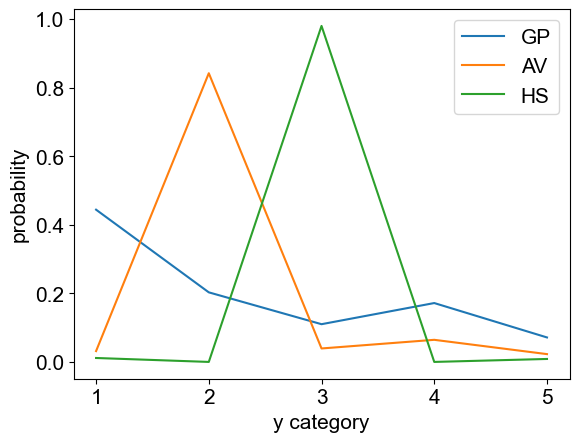

In [9]:
plt.plot([1,2,3,4,5],(y_type_probs.T))
plt.legend(['GP','AV','HS'])
plt.xlabel('y category')
plt.ylabel('probability')
plt.show()

### save data file

In [ ]:
data = R1R2_data

def int_to_roman(num):
    val = [
        1000, 900, 500, 400,
        100, 90, 50, 40,
        10, 9, 5, 4,
        1
    ]
    syms = [
        "M", "CM", "D", "CD",
        "C", "XC", "L", "XL",
        "X", "IX", "V", "IV",
        "I"
    ]
    roman_num = ''
    i = 0
    while num > 0:
        for _ in range(num // val[i]):
            roman_num += syms[i]
            num -= val[i]
        i += 1
    return roman_num


with open('../../plots/Fig_S13B_data.txt', 'w') as f:
    headers = []
    subheaders = []
    for key in data.keys():
        name, type_num = key
        roman_num = int_to_roman(type_num) 
        headers.append(f"{name}, type {roman_num} mutual relative")
        headers.append("")
        subheaders.extend([f"R1", f"R2"])
    
    f.write("\t".join(headers) + "\n")
    f.write("\t".join(subheaders) + "\n")

    max_rows = max(len(data[key][0]) for key in data)
    for i in range(max_rows):
        row = []
        for key in data:
            array1 = data[key][0] 
            if i < len(array1):
                row.extend([str(array1[i][0]), str(array1[i][1])])
            else:
                row.extend(["", ""]) 
        f.write("\t".join(row) + "\n")

### Plot scatter plot

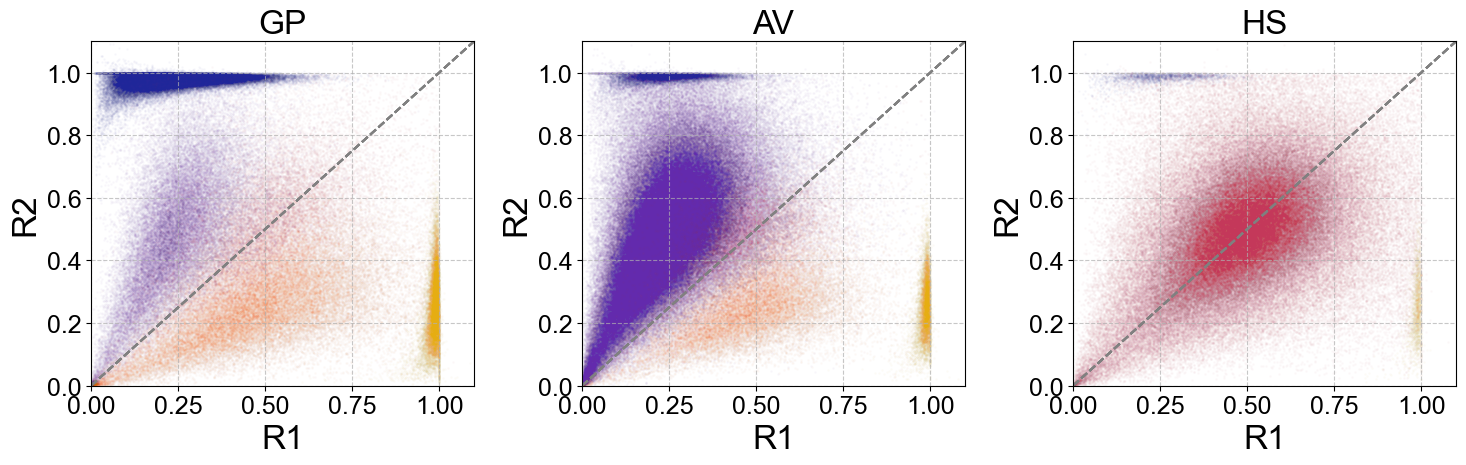

In [20]:
from plot_results import plot_scatter_split_color
palette = sns.color_palette("CMRmap")
palette[0] = (0.12, 0.15, 0.64)

plt.rcParams['font.size'] = 18
fig1 = plot_scatter_split_color(R1R2_data, show_size=False)

# from matplotlib.backends.backend_pdf import PdfPages
# with PdfPages(f'../../plots/Fig_S13A_R1R2_dist.pdf') as pdf:
#     pdf.savefig(fig1)

# plt.savefig('../../plots/Fig_S13A_R1R2_dist.png', dpi=600)

### plot KDEs

In [ ]:
import sys
sys.path.append("..")
from plot_results import plot_kde

bandwith_settings = ['scott','silverman',0.1,0.15,0.2,0.25]
kde_dict = {}
for bandwidth_setting in bandwith_settings:
    _, kdes = plot_kde(R1R2_data, bandwidth = bandwidth_setting, use_weights = False)
    kde_dict[bandwidth_setting] = kdes

## Prediction

Naive bayesian approach

$P(\mathrm{type}|(R_{11},R_{21},...R_{1n},R_{2n})) = \dfrac{P((R_{11},R_{21},...R_{1n},R_{2n})|\mathrm{type})P(\mathrm{type})}{\sum\limits_{\mathrm{all\ types}} P((R_{11},R_{21},...R_{1n},R_{2n})|\mathrm{type})P(\mathrm{type})} \approx \dfrac{P(\mathrm{type})\prod\limits_{i=1}^{n}P((R_{1i},R_{2i})|\mathrm{type})}{\sum\limits_{\mathrm{all\ types}}P(\mathrm{type})\prod\limits_{i=1}^{n}P((R_{1i},R_{2i})|\mathrm{type})}$

$P((R_{1i},R_{2i})|\mathrm{type}) = \sum\limits_{\mathrm{all\ y\ types}}P((R_{1i},R_{2i})|\mathrm{y\ type,type})P(\mathrm{y\ type}|\mathrm{type})$

Conditional probabilities $P((R_{1i},R_{2i})|\mathrm{y\ type,type})$ calculated using KDEs from previous simulations

Type probabilities $P(\mathrm{y\ type}|\mathrm{type})$ calculated from previous simulation data

Prior probabilities $P(\mathrm{type})$ assumed uniform

In [796]:
kdes

{('GP', 1): <scipy.stats._kde.gaussian_kde at 0x7f123e81d510>,
 ('GP', 2): <scipy.stats._kde.gaussian_kde at 0x7f124d4eb190>,
 ('GP', 3): <scipy.stats._kde.gaussian_kde at 0x7f125e574f10>,
 ('GP', 4): <scipy.stats._kde.gaussian_kde at 0x7f124ce70d00>,
 ('GP', 5): <scipy.stats._kde.gaussian_kde at 0x7f124e057d30>,
 ('AV', 1): <scipy.stats._kde.gaussian_kde at 0x7f123f7861d0>,
 ('AV', 2): <scipy.stats._kde.gaussian_kde at 0x7f124e4138b0>,
 ('AV', 3): <scipy.stats._kde.gaussian_kde at 0x7f124e3fbc70>,
 ('AV', 4): <scipy.stats._kde.gaussian_kde at 0x7f123ef1b6d0>,
 ('AV', 5): <scipy.stats._kde.gaussian_kde at 0x7f124ddf45b0>,
 ('HS', 1): <scipy.stats._kde.gaussian_kde at 0x7f123e77f520>,
 ('HS', 3): <scipy.stats._kde.gaussian_kde at 0x7f124e3f0ac0>,
 ('HS', 5): <scipy.stats._kde.gaussian_kde at 0x7f124d4ea4a0>}

In [86]:
def get_y_type_probs(R1R2, kde_dict):
    all_types = ['GP','AV','HS']
    all_y_types = [1,2,3,4,5]
    probs = np.zeros((len(all_types),len(all_y_types)))
    
    for key, kde in kde_dict.items():
        prob = kde(R1R2)
        probs[all_types.index(key[0]),all_y_types.index(key[1])] = prob
    
    return probs

def get_type_probs(R1R2_list, kde_dict, y_type_probs, weights = None, priors = None):
    if priors is None:
        priors = np.array([1/3,1/3,1/3])
    all_types = ['GP','AV','HS']
    for j, R1R2 in enumerate(R1R2_list):
        probs = get_y_type_probs(R1R2, kde_dict) # 3*5

        type_probs = np.sum(probs*y_type_probs,axis = 1)
        
        probs_reverse = get_y_type_probs((R1R2[1],R1R2[0]), kde_dict) # 3*5
        type_probs_reverse = np.sum(probs_reverse*y_type_probs,axis = 1)
        
        if weights is None:
            weight = 1
        else:
            weight = weights[j]
        if j==0:
            final_type_probs = weight*np.log2(type_probs+10**(-5))
            final_type_probs_reverse = weight*np.log2(type_probs_reverse+10**(-5))
        else:
            final_type_probs = final_type_probs + weight*np.log2(type_probs+10**(-5))
            final_type_probs_reverse = final_type_probs_reverse + weight*np.log2(type_probs_reverse+10**(-5))
    
    final_type_probs = 2**final_type_probs
    final_type_probs_reverse = 2**final_type_probs_reverse
    
    summed = np.sum(final_type_probs*priors)+np.sum(final_type_probs_reverse*priors)
    
    final_type_probs = final_type_probs*priors/summed
    final_type_probs_reverse = final_type_probs_reverse*priors/summed
    
    final_type_probs_no_direction = final_type_probs+final_type_probs_reverse
    
    max_ind = np.argmax(final_type_probs_no_direction)
    
    final_type = all_types[max_ind]
    if final_type_probs[max_ind] > final_type_probs_reverse[max_ind]:
        direction = 1
    else:
        direction = 2
    
    return final_type, direction, np.array((final_type_probs,final_type_probs_reverse))

### initial test with BLG data

In [27]:
with open('./BLG_R1R2.data','rb') as file_handle:
    BLG_r1r2 = pickle.load(file_handle)

In [754]:
R1R2_test = list(filter(lambda x: x[0] == ('BLG_M13-75', 'BLG_M13-90'), BLG_r1r2))[0][1]
lens = list(filter(lambda x: x[0] == ('BLG_M13-75', 'BLG_M13-90'), BLG_r1r2))[0][2]

In [735]:
R1R2_test

array([[0.44223454, 0.18945821],
       [0.41423341, 0.44651512],
       [0.51044476, 0.13466363],
       [0.36442887, 0.16812398],
       [0.32300025, 0.09991609]])

In [761]:
final_type, direction, raw_probs = get_type_probs(R1R2_test, kdes, y_type_probs, weights=np.mean(lens,axis = 1)/np.mean(lens))

/tmp/ipykernel_1132/308053694.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probs[all_types.index(key[0]),all_y_types.index(key[1])] = prob


In [762]:
final_type,direction,raw_probs

('AV',
 2,
 array([[1.96940763e-03, 1.06269378e-04, 1.77826552e-04],
        [3.82201986e-03, 9.93757345e-01, 1.67131374e-04]]))

### Summarize BLG data 

In [84]:
def fuzzy_crest_relationship(R1R2_dataset, kdes, y_type_probs, save_path = '', use_weights = False, priors = None):
    all_types = ['GP','AV','HS']
    crest_df = pd.DataFrame(columns=['iid1', 'iid2', 'type', 'direction', 'probability', 'prob_direction', 'prob_GP_1', 'prob_AV_1', 'prob_HS_1', 'prob_GP_2', 'prob_AV_2', 'prob_HS_2'])
    for i, (pair_name, R1R2_data, lens) in enumerate(R1R2_dataset):
        if R1R2_data.any():
            if use_weights:
                weights = np.mean(lens,axis = 1)/np.mean(lens)
                final_type, direction, raw_probs = get_type_probs(R1R2_data, kdes, y_type_probs, weights = weights, priors = priors)
            else:
                final_type, direction, raw_probs = get_type_probs(R1R2_data, kdes, y_type_probs, priors = priors)
            crest_df.loc[i,'iid1'] = pair_name[0]
            crest_df.loc[i,'iid2'] = pair_name[1]
            crest_df.loc[i,'type'] = final_type
            crest_df.loc[i,'direction'] = direction
            crest_df.loc[i,'probability'] = raw_probs[0,all_types.index(final_type)] + raw_probs[1,all_types.index(final_type)]
            crest_df.loc[i,'prob_direction'] = raw_probs[direction-1,all_types.index(final_type)]/crest_df.loc[i,'probability']
            
            for j,name in enumerate(['GP','AV','HS']):
                crest_df.loc[i,f'prob_{name}_1'] = raw_probs[0,j]
                crest_df.loc[i,f'prob_{name}_2'] = raw_probs[1,j]
    if save_path:
        crest_df.to_csv(save_path,)
    return crest_df

In [87]:
with open('./BLG_R1R2_35.data','rb') as file_handle:
    BLG_r1r2 = pickle.load(file_handle)
crest_df = fuzzy_crest_relationship(BLG_r1r2, kde_dict['scott'], y_type_probs, save_path = './result_csvs/BLG_pop100.csv', use_weights=False)
crest_df.to_csv('BLG_crest_df.csv')
crest_df

/tmp/ipykernel_1249/3021134730.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probs[all_types.index(key[0]),all_y_types.index(key[1])] = prob


,iid1,iid2,type,direction,probability,prob_direction,prob_GP_1,prob_AV_1,prob_HS_1,prob_GP_2,prob_AV_2,prob_HS_2
0,BLG_M13-4,BLG_M13-86,HS,2,0.968835,0.554992,0.000381,0.030139,0.43114,0.000328,0.000316,0.537696
1,BLG_M13-75,BLG_M13-7,HS,1,0.725054,0.529961,0.010422,0.015491,0.38425,0.013673,0.23536,0.340804
3,BLG_M13-75,BLG_M13-90,AV,2,0.994074,0.999904,0.00204,0.000095,0.000149,0.003588,0.993979,0.00015
4,BLG_M13-7,BLG_M13-90,AV,2,0.999538,0.999993,0.000132,0.000007,0.000025,0.000287,0.99953,0.000018


### Validation with independently generated artificial data

In [10]:
def fuzzy_crest_relationship_validation(R1R2_dataset, kdes, y_type_probs, save_path = '', use_weights = False):
    all_types = ['GP','AV','HS']
    crest_df = pd.DataFrame(columns=['iid1', 'iid2', 'type','true type', 'direction', 'y number', 'probability', 'prob_direction', 'prob_GP_1', 'prob_AV_1', 'prob_HS_1', 'prob_GP_2', 'prob_AV_2', 'prob_HS_2'])
    for i, (pair_name, true_type, R1R2_data, lens, _) in enumerate(R1R2_dataset):
        if R1R2_data.any():
            if use_weights:
                weights = np.mean(lens,axis = 1)/np.mean(lens)
                final_type, direction, raw_probs = get_type_probs(R1R2_data, kdes, y_type_probs, weights = weights)
            else:
                final_type, direction, raw_probs = get_type_probs(R1R2_data, kdes, y_type_probs)
            crest_df.loc[i,'iid1'] = pair_name[0]
            crest_df.loc[i,'iid2'] = pair_name[1]
            crest_df.loc[i,'type'] = final_type
            crest_df.loc[i,'true type'] = true_type
            crest_df.loc[i,'direction'] = direction
            crest_df.loc[i,'y number'] = R1R2_data.shape[0]
            crest_df.loc[i,'probability'] = raw_probs[0,all_types.index(final_type)] + raw_probs[1,all_types.index(final_type)]
            crest_df.loc[i,'prob_direction'] = raw_probs[direction-1,all_types.index(final_type)]/crest_df.loc[i,'probability']
            
            for j,name in enumerate(['GP','AV','HS']):
                crest_df.loc[i,f'prob_{name}_1'] = raw_probs[0,j]
                crest_df.loc[i,f'prob_{name}_2'] = raw_probs[1,j]
    if save_path:
        crest_df.to_csv(save_path,)
    return crest_df

In [ ]:
# 0407: retry with same setting as training set, with sampling

reps = 25
samp_reps = 3
crest_df_lst = []
confusion_matrix = np.zeros((3,3))
for i in range(reps):
    timestamp = time.strftime("%H_%M_%S")
    basename =  run_pedsim_pipeline(generations=10, size = (150,200), mean_children=1.5, mean_spouse_num=1.5, max_generation_size=40, name = f'test_{timestamp}')
    get_coef_from_fam(f'{basename}-everyone.fam')
    
    fam = pd.read_csv(f'{basename}-everyone.fam',sep = ' ',header=None)
    coef = pd.read_csv(f'{basename}.coef',sep = '\t',header=None)
    seg = pd.read_csv(f'{basename}.seg',sep = '\t',header=None)

    for j in range(samp_reps):
        all_R1_R2s = get_R1_R2_stat_sample(seg, coef, fam, order_thres = (3,5), reorder = False, return_length = True, noise=0.5, sample_num=40)
        
        crest_df = fuzzy_crest_relationship_validation(all_R1_R2s, kde_dict['scott'], y_type_probs)
        crest_df_lst.append(crest_df)
        
        for ind,row in crest_df.iterrows():
            all_types = ['GP','AV','HS']
            confusion_matrix[all_types.index(row['type']), all_types.index(row['true type'])] += 1  
    
with open('./data_backup/0407_crest_df_lst.data','wb') as file_handle:
    pickle.dump(crest_df_lst,file_handle)

In [11]:
basename_lst_all = [f'./pedsim_data/2024_03_21/{folder}' for folder in os.listdir('./pedsim_data/2024_03_21')]
len(basename_lst_all)

103

In [267]:
# with sampling
reps = 60
# crest_df_lst = []
crest_df_dict = {}
confusion_matrix = np.zeros((3,3,len(bandwith_settings)))
basename_lst_all = sorted([f'./pedsim_data/2024_03_21/{folder}' for folder in os.listdir('./pedsim_data/2024_03_21')])
basename_lst = sorted(np.random.choice(basename_lst_all,reps).tolist())

for i in range(reps):
    timestamp = time.strftime("%H_%M_%S")
    filename = os.path.splitext(sorted(os.listdir(basename_lst[i]))[3])[0]
    print(filename)
    basename = f'{basename_lst[i]}/{filename}'
    get_coef_from_fam(f'{basename}-everyone.fam')
    
    # basename =  run_pedsim_pipeline(generations=8, size = (125,150), mean_children=1.5, mean_spouse_num=2.5, max_generation_size=40, name = f'test_{timestamp}')
    # get_coef_from_fam(f'{basename}-everyone.fam')
    
    fam = pd.read_csv(f'{basename}-everyone.fam',sep = ' ',header=None)
    coef = pd.read_csv(f'{basename}.coef',sep = '\t',header=None)
    seg = pd.read_csv(f'{basename}.seg',sep = '\t',header=None)

    all_R1_R2s = get_R1_R2_stat_sample(seg, coef, fam, order_thres = (2,5), reorder = False, return_length = True, noise=0.5, sample_num=40)
    with open(f'{basename}_sample_R1R2.data','wb') as file_handle:
        pickle.dump(all_R1_R2s,file_handle)
    
    for ind_bw, setting in enumerate(bandwith_settings):
        kdes = kde_dict[setting]
        crest_df = fuzzy_crest_relationship_validation(all_R1_R2s, kdes, y_type_probs)
        if setting not in crest_df_dict.keys():
            crest_df_dict[setting] = []
        crest_df_dict[setting].append(crest_df)
    
        for ind,row in crest_df.iterrows():
            all_types = ['GP','AV','HS']
            confusion_matrix[all_types.index(row['type']), all_types.index(row['true type']), ind_bw] += 1  

for i in range(len(basename_lst_all)):
    timestamp = time.strftime("%H_%M_%S")
    filename = os.path.splitext(sorted(os.listdir(basename_lst[i]))[3])[0]
    print(filename)
    basename = f'{basename_lst_all[i]}/{filename}'
    
    # basename =  run_pedsim_pipeline(generations=8, size = (125,150), mean_children=1.5, mean_spouse_num=2.5, max_generation_size=40, name = f'test_{timestamp}')
    get_coef_from_fam(f'{basename}-everyone.fam')
    
    fam = pd.read_csv(f'{basename}-everyone.fam',sep = ' ',header=None)
    coef = pd.read_csv(f'{basename}.coef',sep = '\t',header=None)
    seg = pd.read_csv(f'{basename}.seg',sep = '\t',header=None)
    
    if not os.path.exists(f'{basename}_sample_R1R2.data'):
        all_R1_R2s = get_R1_R2_stat_sample(seg, coef, fam, order_thres = (2,5), reorder = False, return_length = True, noise=0.5, sample_num=40)
        with open(f'{basename}_sample_R1R2.data','wb') as file_handle:
            pickle.dump(all_R1_R2s,file_handle)
            

In [ ]:
p_thres = 0.72
ynum_thres = (3,100)

confusion_matrix = np.zeros((3,3))

crest_df_lst = crest_df_dict['scott']
for crest_df_raw in crest_df_lst:
    crest_df = crest_df_raw[(crest_df_raw['probability']>p_thres) & (crest_df_raw['y number']>ynum_thres[0]) & (crest_df_raw['y number']<ynum_thres[1])]
    for ind,row in crest_df.iterrows():
        all_types = ['GP','AV','HS']
        confusion_matrix[all_types.index(row['type']), all_types.index(row['true type'])] += 1  

In [ ]:
# precision
print(confusion_matrix)
print(confusion_matrix[0,0]/np.sum(confusion_matrix[0,:]))
print(confusion_matrix[1,1]/np.sum(confusion_matrix[1,:]))
print(confusion_matrix[2,2]/np.sum(confusion_matrix[2,:]))
print(np.sum(confusion_matrix[[0,1,2],[0,1,2]])/np.sum(confusion_matrix))

[[3373.  710.  255.]
 [1291. 4893.  721.]
 [ 601.  603. 2956.]]
0.7775472568003688
0.7086169442433019
0.7105769230769231
0.7285593715509966


In [ ]:
# recall
print(confusion_matrix)
print(confusion_matrix[0,0]/np.sum(confusion_matrix[:,0]))
print(confusion_matrix[1,1]/np.sum(confusion_matrix[:,1]))
print(confusion_matrix[2,2]/np.sum(confusion_matrix[:,2]))

[[3414.  736.  261.]
 [1347. 4971.  785.]
 [ 626.  661. 3000.]]
0.6337479116391312
0.7806218592964824
0.7414730598121602


In [227]:
with open('./data_backup/0321_crest_df_lst.data','wb') as file_handle:
    pickle.dump(crest_df_lst,file_handle)